In [4]:
!pip install -q datasets transformers evaluate accelerate

In [5]:
import sys
from pathlib import Path

# Add the project root directory to the Python path
notebook_dir = Path().resolve()
project_root  = notebook_dir.parent
sys.path.append(str(project_root))

# Dataset

In [6]:
from datasets import Dataset, DatasetDict, Image

/home/panos/dev/hf_seg/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import os

def get_sorted_file_list(folder):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    files.sort(key=lambda x: os.path.basename(x))
    return files


def get_dataset(type: str):
    root_dir = '/home/panos/Documents/data/kitti/data_semantics'
    root_dir = os.path.join(root_dir, type)
    
    image_folder='image_2'
    image_dir = os.path.join(root_dir, image_folder)
    images = get_sorted_file_list(image_dir)
    
    if type == 'training':
        mask_folder='semantic'
        mask_dir = os.path.join(root_dir, mask_folder)
        masks = get_sorted_file_list(mask_dir)
    else:
        masks = []


    return images, masks

In [8]:
image_paths_train, label_paths_train = get_dataset("training")
image_paths_test, label_paths_test = get_dataset("testing")

In [9]:
import random

# Combine image and label paths to ensure consistent shuffling
combined = list(zip(image_paths_train, label_paths_train))
random.shuffle(combined)

# Unzip the shuffled list
image_paths_train, label_paths_train = zip(*combined)

# Perform the split
split_index = int(len(image_paths_train) * 0.8)
image_paths_validation = image_paths_train[split_index:]
label_paths_validation = label_paths_train[split_index:]
image_paths_train = image_paths_train[:split_index]
label_paths_train = label_paths_train[:split_index]

# Convert back to lists
image_paths_train = list(image_paths_train)
label_paths_train = list(label_paths_train)
image_paths_validation = list(image_paths_validation)
label_paths_validation = list(label_paths_validation)

In [10]:
def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

# step 1: create Dataset objects
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

# step 2: create DatasetDict
dataset = DatasetDict({
     "train": train_dataset,
     "validation": validation_dataset,
     }
)

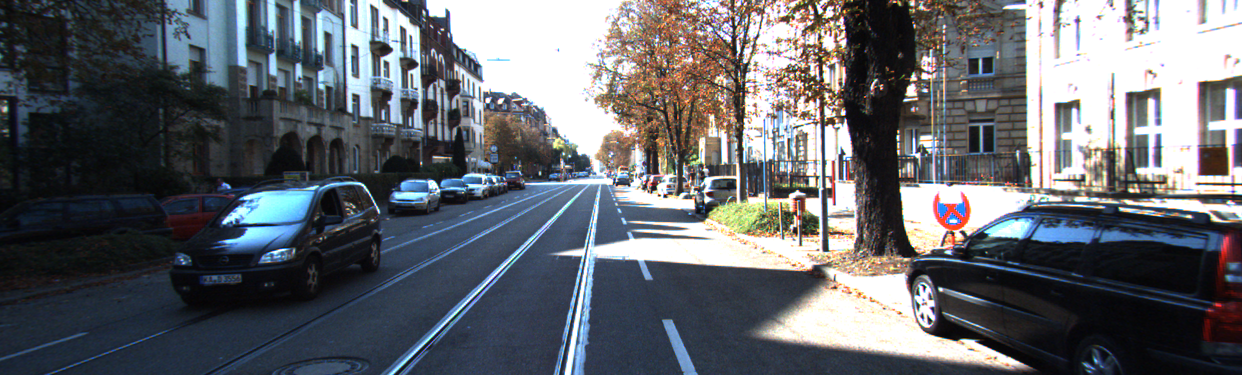

In [11]:
first_image = train_dataset[0]["image"]
first_label = train_dataset[0]["label"]

# Display the image and label
first_image

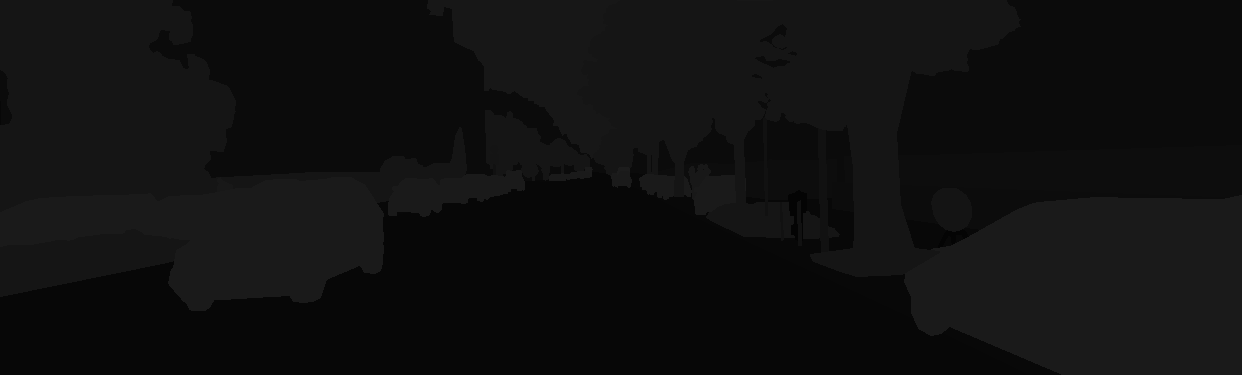

In [12]:
first_label

In [13]:
import json

# Load the local id2label.json file
with open("../data/id2label.json", "r") as fp:
    id2label = json.load(fp)

# Convert keys to integers
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
num_labels

35

# Evaluation

In [14]:
import evaluate

metric = evaluate.load("mean_iou")

In [15]:
import numpy as np
import torch
from torch import nn

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                metrics[key] = value.tolist()
        return metrics

# Model

## Backbone

In [ ]:
from transformers import AutoImageProcessor, AutoModel

BACKBONE_MODEL = 'facebook/dinov2-small'

backbone_processor = AutoImageProcessor.from_pretrained(BACKBONE_MODEL, use_fast=False)
backbone_model = AutoModel.from_pretrained(BACKBONE_MODEL)

inputs = backbone_processor(images=first_image, return_tensors="pt")
with torch.no_grad():
    outputs = backbone_model(**inputs)
last_hidden_states = outputs.last_hidden_state


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [17]:
last_hidden_states.shape

torch.Size([1, 257, 384])

## Segmentation head

In [18]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

HEAD_MODEL = "facebook/mask2former-swin-small-ade-semantic"

# Load a pretrained segmentation model
segmentation_processor = AutoImageProcessor.from_pretrained(HEAD_MODEL)
segmentation_model = Mask2FormerForUniversalSegmentation.from_pretrained(HEAD_MODEL)

inputs = segmentation_processor(images=first_image, return_tensors="pt")
with torch.no_grad():
    outputs = segmentation_model(**inputs)

/home/panos/dev/hf_seg/.venv/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [19]:
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits
pixel_features = outputs.pixel_decoder_last_hidden_state
print(pixel_features.shape, class_queries_logits.shape, masks_queries_logits.shape)

torch.Size([1, 256, 96, 96]) torch.Size([1, 100, 151]) torch.Size([1, 100, 96, 96])


## Full model

In [16]:
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerConfig, Dinov2Config

# DinoV2 backbone
# dino_cfg = Dinov2Config.from_pretrained(BACKBONE_MODEL)
# mask2former_cfg.backbone_config = dino_cfg
cfg = Mask2FormerConfig.from_pretrained(HEAD_MODEL)
cfg.d_model           = backbone_model.config.hidden_size    # 384
cfg.hidden_size       = backbone_model.config.hidden_size
cfg.num_labels        = num_labels

# Segformer head
model = Mask2FormerForUniversalSegmentation(cfg)
model.model.encoder = backbone_model
# re-init the query embeddings
model.model.query_embed = nn.Embedding(cfg.num_queries, cfg.d_model)
# re-init the linear layer that turns each query into a class score
model.model.class_queries_proj = nn.Linear(cfg.d_model, cfg.num_labels)

inputs = backbone_processor(images=first_image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

In [17]:
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits
pixel_features = outputs.pixel_decoder_last_hidden_state
print(pixel_features.shape, class_queries_logits.shape, masks_queries_logits.shape)

torch.Size([1, 256, 56, 56]) torch.Size([1, 100, 36]) torch.Size([1, 100, 56, 56])


# Inference

In [18]:
# Preprocess the image
inputs = backbone_processor(images=first_image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

In [19]:
print(first_image.size, outputs.class_queries_logits.shape, outputs.masks_queries_logits.shape)

(1242, 375) torch.Size([1, 100, 36]) torch.Size([1, 100, 56, 56])


In [20]:
pred_semantic_map = segmentation_processor.post_process_semantic_segmentation(
    outputs, target_sizes=[(first_image.height, first_image.width)]
)[0]
print(first_image.size, pred_semantic_map.shape)

(1242, 375) torch.Size([375, 1242])


(375, 1242, 3)
(375, 1242)


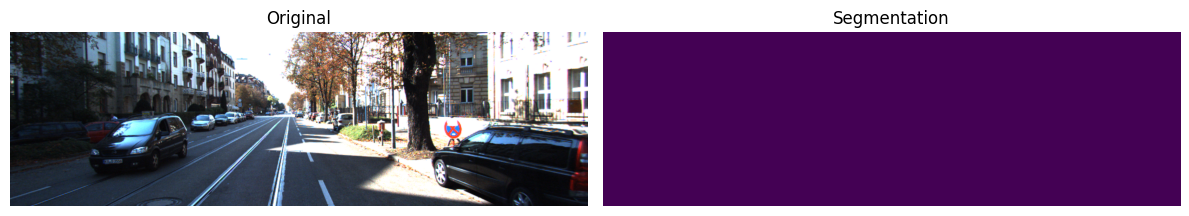

In [21]:
import matplotlib.pyplot as plt
import numpy as np

print(np.array(first_image).shape)
print(pred_semantic_map.cpu().numpy().shape)

# plot side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.imshow(np.array(first_image)); 
ax1.set_title("Original");    
ax1.axis("off")

ax2.imshow(pred_semantic_map.cpu().numpy()); 
ax2.set_title("Segmentation"); 
ax2.axis("off")

plt.tight_layout()
plt.show()


# DEBUG